# Second exercise: kernel-PCA

Data source: https://github.com/alexdepremia/Unsupervised-Learning-Datasets

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
import pandas as pd
import scipy as sp

In [2]:
# reading the data
X = np.loadtxt('data/data_kPCA.txt', dtype=float)
print("Dimension of the dataset: ", X.shape)
labels = np.loadtxt('data/labels_kPCA.txt', dtype=int)

Dimension of the dataset:  (10000, 10)


---

1. Preprocess the data in the first file by centering the variables and divide them by their standard deviation.

In [3]:
import sys
sys.path.append('../')
from _1.first_exercise import get_PC, plot_PC, normalize, plot_log_spectrum

X = normalize(X)

---

2. Divide the dataset into two. One (with the first $1000$ data points and labels) would be employed as test set, while the other (the last $9000$ data points) would be employed as leaerning data.

In [4]:
test_idx = np.arange(0, 1000)  # indexes for splitting the data

---

3. Use the program from the previous exercise for computing the Principal Components Analysis on the learning data set. Obtain and plot the eigenvalue spectrum using logscale for the y-axis. Project the data in the two first PCs and color it by label.

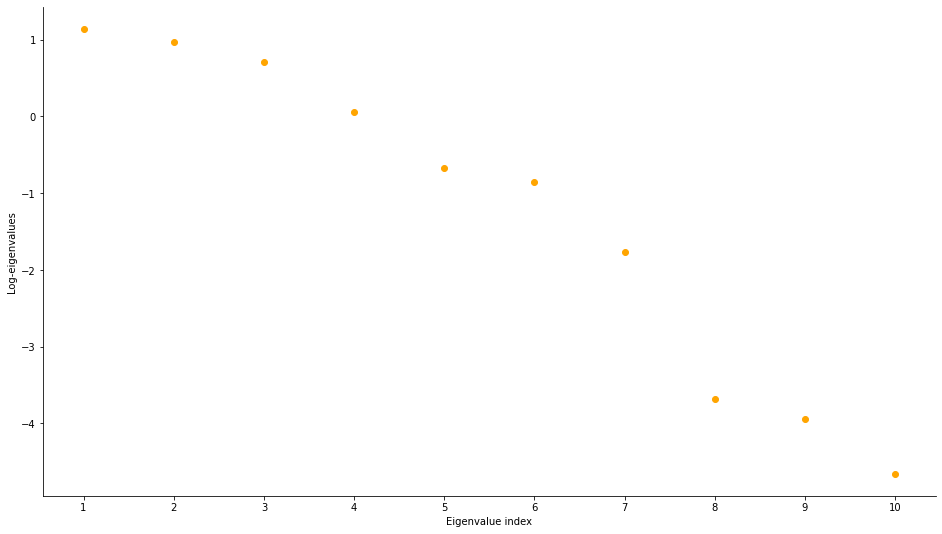

In [5]:
# plot the log-spectrum of the eigenvalues and get first two PC
Y = get_PC(X, 2, plot=True)

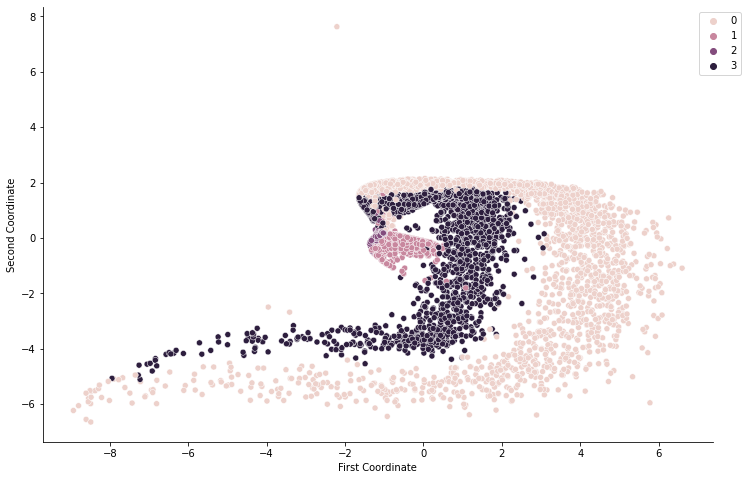

In [6]:
# plot coloring by the label column
plot_PC(Y, labels)

---

4. (a) Apply a multinomial logistic regression for learning a model in the learning data set.

Sources: 
 - algortihmic structure: https://web.stanford.edu/~hastie/Papers/glmnet.pdf
 - optimization: http://machinelearningmechanic.com/deep_learning/2019/09/04/cross-entropy-loss-derivative.html
 
4. (b) Trasform the coordinates of the test data set with the matrix learned from the learning data set and make a prediction based on the logistic model. Quantify the quality of the prediction by computing the Mutual Information between the ground truth classification and the predicted labels.

In [7]:
# linear prediction function: z = Wx + b (logit scores)
# with W = [#labels, #features], X = [#features, 1], B = [#labels, 1] --> z = [#labels, 1]
def linear_layer(X, W, b):
    Z = np.array([np.empty([W.shape[0]]) for j in range(X.shape[0])]) # z = [#data, #labels] 
    for i in range(X.shape[0]):
        Z[i] = (np.matmul(W, (X[i].T)).reshape(-1, 1) + b).reshape(-1)
    return Z

# softmax layer: softmax(z_i)
def softmax_layer(Z):
    prob = np.zeros_like(Z)
    for i in range(Z.shape[0]):
        max_num = np.max(Z[i, :], keepdims=True)  # prevent overflow of exponential
        num = np.exp(Z[i, :] - max_num)
        den = np.sum(num)
        prob[i] = num/den
    return prob

# predict the most likely label for each data point
def prediction_layer(prob):
    predictions = np.array([np.argmax(i) for i in prob])
    return predictions

# stacking layers together
def multinomial_logistic_regression(X, W, b):
    Z = linear_layer(X, W, b)
    P = softmax_layer(Z)
    y_hat = prediction_layer(P)
    return P, y_hat

# loss function used to optimize parameters: cross entropy loss
def cross_entropy_loss(P, labels):
    n_data = P.shape[0]
    loss = 0
    for prob, label in zip(P, labels):
        if(prob[label] == 0):
            prob[label] = 1e-10 # avoid division by 0
        # assuming labels are 1-hot encoded
        loss += -np.log(prob[label])
    loss /= n_data
    return loss

# optimizing with stochastic gradient descent
def training(X, labels, learning_rate=0.05, epochs=500):
    # random initialization of weights abd biases:
    n_features = X.shape[1]
    n_labels = len(np.unique(labels))
    n_data = X.shape[0]
    W = np.random.rand(n_labels, n_features)
    b = np.random.rand(n_labels, 1)
    losses = np.array([])
    # training loop
    for i in range(epochs):
        prob, _ = multinomial_logistic_regression(X, W, b)
        loss = cross_entropy_loss(prob, labels)
        losses = np.append(losses, loss)
        # gradients
        prob[np.arange(n_data), labels] -= 1
        dLdW = np.matmul(prob.T, X)
        dLdb = np.sum(prob, axis=0).reshape(-1, 1)
        # update W, b
        W -= (learning_rate * dLdW)
        b -= (learning_rate * dLdb)
    return W, b, losses

# quantifying the quality of the prediction
def mutual_information(x, y):
    # x is true class, y is predicted class
    MI = 0.0
    x_classes = np.unique(x)
    y_classes = np.unique(y)
    px = np.array([len(x[x==x_class])/float(len(x)) for x_class in x_classes]) # p(x)
    py = np.array([len(y[y==y_class])/float(len(x)) for y_class in y_classes]) # p(y)
    for i in range(len(x_classes)):
        if px[i] == 0:
            continue
        # components of y whose label is current x_class, i.e. intersection of x and y
        sy = y[x==x_classes[i]]
        if len(sy) == 0:
            continue
        pxy = np.array([len(sy[sy==y_class])/float(len(y)) for y_class in y_classes]) # p(x, y)
        frac = pxy[py>0.]/(py[py>0.] * px[i])
        # summing over all y_classes for current x_class
        MI += np.sum(pxy[pxy>0.]*np.log2(frac[frac>0.]))
    return MI

# testing the quality of the prediction
def testing(X, labels, W, b):
    P, y_hat = multinomial_logistic_regression(X, W, b)
    return mutual_information(labels, y_hat)

# multinomial logistic regression on a certain number of principal components
def pc_mlr(pc_train, labels_train, pc_test, labels_test):
    W, b, losses = training(pc_train, labels_train)
    MI = testing(pc_test, labels_test, W, b)
    return MI

# multinomial logistic regression on a varying number of principal components
def var_pc_mlr(X, labels, min_components, max_components, test_idx):
    # compute PC
    Y = get_PC(X, max_components)
    # train - test split
    Y_test = Y[test_idx, :]
    labels_test = labels[test_idx]
    Y_train = Y[test_idx[-1]+1:, :]
    labels_train = labels[test_idx[-1]+1:]  
    MIs = []
    for i in range(min_components, max_components+1):
        pc_train = Y_train[:, :i]
        pc_test = Y_test[:, :i]
        MI = pc_mlr(pc_train, labels_train, pc_test, labels_test)
        print("Num PCs: ", i, ", Mutual Information: ", MI)
        MIs.append(MI)
    return MIs

---

4. Repeat 4(a) and 4(b) for a number of principal components ranging from $1$ to $10$.

In [8]:
_ = var_pc_mlr(X, labels, 1, 10, test_idx)

Num PCs:  1 , Mutual Information:  0.017774225203491985
Num PCs:  2 , Mutual Information:  0.4074680498251149
Num PCs:  3 , Mutual Information:  1.2304373977533911
Num PCs:  4 , Mutual Information:  1.471394688801934
Num PCs:  5 , Mutual Information:  1.030592540670483
Num PCs:  6 , Mutual Information:  1.6867923515906205
Num PCs:  7 , Mutual Information:  1.4703258660342224
Num PCs:  8 , Mutual Information:  1.73519599867712
Num PCs:  9 , Mutual Information:  1.7483380161275464
Num PCs:  10 , Mutual Information:  1.8037532925999031


Multinomial Logistic Regreassion with _sklearn_ functions (faster):

In [9]:
def var_pc_mlr_sk(X, labels, min_components, max_components, test_idx):
    Y = get_PC(X, 10)
    Y_test = Y[test_idx, :]
    labels_test = labels[test_idx]
    Y_train = Y[test_idx[-1]+1:, :]
    labels_train = labels[test_idx[-1]+1:] 

    model = LogisticRegression(multi_class='multinomial', max_iter=1000)
    for i in range(min_components, max_components+1):
        X_train = Y_train[:, :i]
        X_test = Y_test[:, :i]
        model.fit(X_train, labels_train)
        Y_hat = model.predict(X_test)
        print("Num PC: ", i, 
          "Mutual Information: ", '{:.4f}'.format(mutual_information(labels_test, Y_hat)), 
          "Accuracy: ", accuracy_score(labels_test, Y_hat, normalize=True))

In [10]:
var_pc_mlr_sk(X, labels, 1, 10, test_idx)

Num PC:  1 Mutual Information:  0.7163 Accuracy:  0.636
Num PC:  2 Mutual Information:  0.7701 Accuracy:  0.661
Num PC:  3 Mutual Information:  1.5000 Accuracy:  0.867
Num PC:  4 Mutual Information:  1.6816 Accuracy:  0.936
Num PC:  5 Mutual Information:  1.7034 Accuracy:  0.942
Num PC:  6 Mutual Information:  1.7371 Accuracy:  0.949
Num PC:  7 Mutual Information:  1.7284 Accuracy:  0.949
Num PC:  8 Mutual Information:  1.8192 Accuracy:  0.97
Num PC:  9 Mutual Information:  1.8279 Accuracy:  0.972
Num PC:  10 Mutual Information:  1.8691 Accuracy:  0.98


---

5. Implement kernel-PCA with a Gaussian kernel. Use as width, for instance, the average distance from the fifth nearest neighbor for each data points.

In [11]:
# compute pair-wise euclidean distance
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x-y)**2, axis=-1))
    
# compute distance matrix: D[i, j] distance between X^i and X^j
def distance_mat(X):
    return euclidean_distance(X[:, np.newaxis, :], X[np.newaxis, :, :])

# find, for each point, the fifth nearest neighbor 
# and average across all points
def compute_width(D, n_neigh=5):
    sorted_dist = np.sort(D, axis=1)
    dist_neigh = sorted_dist[:, n_neigh]  # excluding point itself
    # useful for isomap
    d = dist_neigh.reshape(len(dist_neigh), 1)
    return d, dist_neigh.mean()

# compute matrix K
def compute_kernel(D):
    _, width = compute_width(D)
    gamma = 1/(2*(width**2))
    K = np.exp(-gamma*(D**2))
    return K

# compute Gram matrix G by double centering
def double_centering(K, kernel=True):
    n_data = K.shape[0]
    s1 = np.sum(K)  # all elements sum
    c2 = 1/n_data 
    c1 = (c2**2) 
    row_sum = np.sum(K, axis=1)
    s3 = np.zeros_like(K) + row_sum
    s2 = s3 + s3.T
    G = K - c2*s2 + c1*s1
    if kernel is False:
        G = G*(-1/2)
    # for i in range(n_data):
    #    for j in range(i+1, n_data):
    #        s2 = np.sum([K[i, l] + K[l, j] for l in range(n_data)])
    #        G[i, j] = -(K[i, j] - c2*s2 + c1*s1)/2
    #        G[j, i] = G[i, j]
    return G

def multi_dimensional_scaling(K, d, kernel=True):
    G = double_centering(K, kernel)
    # eigenvalues in increasing order (take last d)
    evalues, evectors = sp.linalg.eigh(G, eigvals=(len(G)-d, len(G)-1))
    Y = np.multiply(evectors, np.sqrt(evalues))[:,::-1]
    return evalues, Y, G

Verify that MDS with squared euclidean distance is actually PCA:

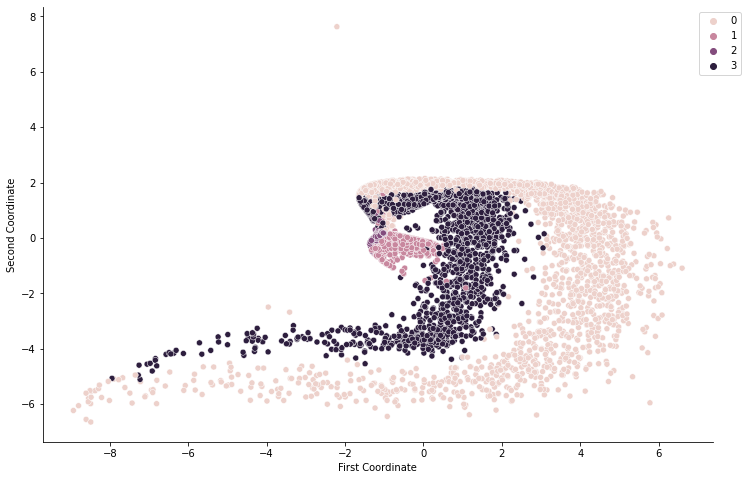

In [12]:
D = distance_mat(X)
_, Y, _ = multi_dimensional_scaling(D**2, 2, kernel=False)
plot_PC(Y, labels)

---

5. (3) Compute kernel-PCA, obtain and project the eigenvalue spectrum using logscale for the y-axis.

In [13]:
def compute_kernel_PCA(X, num_components, plot=False):
    D = distance_mat(X)
    K = compute_kernel(D)
    _, Y, G = multi_dimensional_scaling(K, num_components, kernel=True)
    if plot:
        evalues = sp.linalg.eigh(G, eigvals_only=True)
        plot_log_spectrum(evalues[::-1])
    return Y

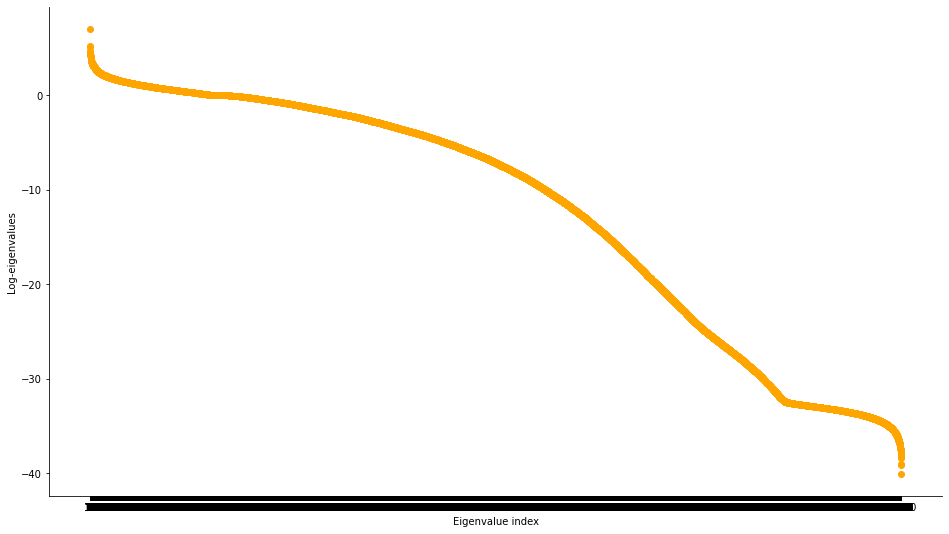

In [14]:
Y = compute_kernel_PCA(X, 2, plot=True)

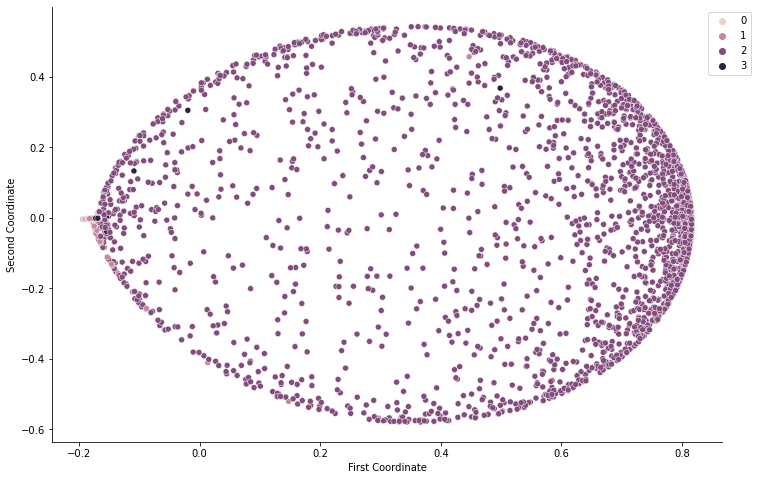

In [15]:
# plot coloring by the label column
plot_PC(Y, labels)

---

5. (4) For d=$1, ..., 10$ apply a multinomial logistic regression for learning a model in the learning data set. Then transform the coordinates of the test data set and make a prediction based on the logistic model. Quantify the quality of the prediction by computing the Mutual Information between the ground truth classification and the predicted labels.

In [16]:
# multinomial logistic regression on a varying number of kernel-PC
def var_kpc_mlr(X, labels, min_components, max_components, test_idx):
    # compute PC
    Y = compute_kernel_PCA(X, max_components)
    # train - test split
    Y_test = Y[test_idx, :]
    labels_test = labels[test_idx]
    Y_train = Y[test_idx[-1]+1:, :]
    labels_train = labels[test_idx[-1]+1:]  
    MIs = []
    for i in range(min_components, max_components+1):
        pc_train = Y_train[:, :i]
        pc_test = Y_test[:, :i]
        MI = pc_mlr(pc_train, labels_train, pc_test, labels_test)
        print("Num KPCs: ", i, "Mutual Information: ", MI)
        MIs.append(MI)
    return MIs

In [17]:
_ = var_kpc_mlr(X, labels, 1, 10, test_idx)

Num KPCs:  1 Mutual Information:  0.6249531483756684
Num KPCs:  2 Mutual Information:  0.6386790098591304
Num KPCs:  3 Mutual Information:  0.5840610827162024
Num KPCs:  4 Mutual Information:  0.6436450520624946
Num KPCs:  5 Mutual Information:  0.6386790098591304
Num KPCs:  6 Mutual Information:  0.5973250026216186
Num KPCs:  7 Mutual Information:  0.7044329638710229
Num KPCs:  8 Mutual Information:  0.707103450745836
Num KPCs:  9 Mutual Information:  0.7616456163847194
Num KPCs:  10 Mutual Information:  0.7417819884694076


In [18]:
def var_kpc_mlr_sk(X, labels, min_components, max_components, test_idx):
    Y = compute_kernel_PCA(X, 10)
    Y_test = Y[test_idx, :]
    labels_test = labels[test_idx]
    Y_train = Y[test_idx[-1]+1:, :]
    labels_train = labels[test_idx[-1]+1:] 

    model = LogisticRegression(multi_class='multinomial', solver='saga')
    for i in range(min_components, max_components+1):
        X_train = Y_train[:, :i]
        X_test = Y_test[:, :i]
        model.fit(X_train, labels_train)
        Y_hat = model.predict(X_test)
        print("Num PC: ", i, 
              "Mutual Information: ", '{:.4f}'.format(mutual_information(labels_test, Y_hat)), 
              "Accuracy: ", accuracy_score(labels_test, Y_hat, normalize=True))

In [19]:
var_kpc_mlr_sk(X, labels, 1, 10, test_idx)

Num PC:  1 Mutual Information:  0.9050 Accuracy:  0.642
Num PC:  2 Mutual Information:  0.9120 Accuracy:  0.644
Num PC:  3 Mutual Information:  0.9723 Accuracy:  0.627
Num PC:  4 Mutual Information:  1.0228 Accuracy:  0.679
Num PC:  5 Mutual Information:  1.0179 Accuracy:  0.686
Num PC:  6 Mutual Information:  1.0211 Accuracy:  0.687
Num PC:  7 Mutual Information:  0.9844 Accuracy:  0.691
Num PC:  8 Mutual Information:  0.9836 Accuracy:  0.691
Num PC:  9 Mutual Information:  1.0376 Accuracy:  0.729
Num PC:  10 Mutual Information:  1.0293 Accuracy:  0.727


---

6. Implement ISOMAP, project the data set into 2D and color by label

In [20]:
# Floyd algorithm for estimating the geodesic distance
def floyd_algorithm(D, n_neigh):
    n_data = D.shape[0]
    # initialization
    Delta = D
    # distance from first n_neigh for each point
    dist_neigh, _ = compute_width(D, n_neigh=n_neigh)  
    Delta[np.where(D>dist_neigh)] = np.inf
    # refinement
    # symmetrize Delta and set diagonal to 0
    for i in range(n_data):
        Delta[i, i] = 0
        for j in range(i+1, n_data):
            if Delta[j, i] <= Delta[i, j]:
                Delta[i, j] = Delta[j, i]
            else:
                Delta[j, i] = Delta[i, j]
    # compute shortest paths
    for k in range(n_data):
        Delta = np.minimum(Delta, Delta[np.newaxis,k,:] + Delta[:,k,np.newaxis]) 
    # for k in range(n_data):
    #    for i in range(n_data):
    #        for j in range(n_data):
    #            if(Delta[i, j] > Delta[i,k] + Delta[k, j]):
    #                Delta[i, j] = Delta[i,k] + Delta[k, j]
    Delta **= 2
    return Delta

def isomap(X, n_neigh, n_components, plot=False):
    D = distance_mat(X)
    Delta = floyd_algorithm(D, n_neigh)
    evalues, Y, G = multi_dimensional_scaling(Delta, n_components, kernel=False)
    if plot:
        evalues = sp.linalg.eigh(G, eigvals_only=True)
        plot_log_spectrum(evalues)
    return Y

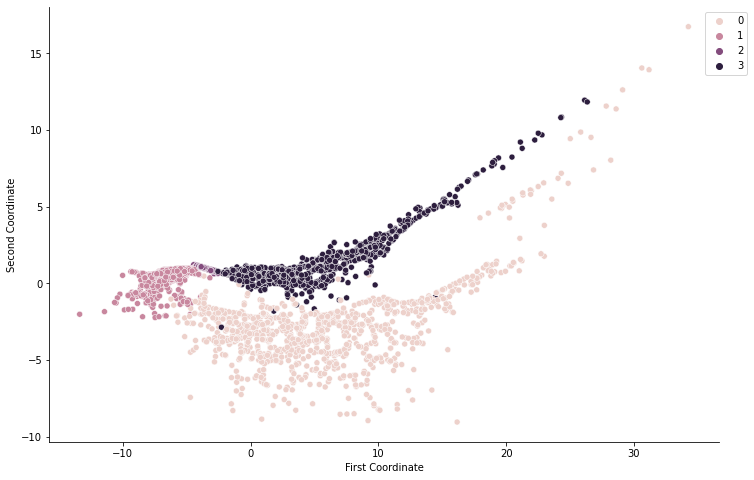

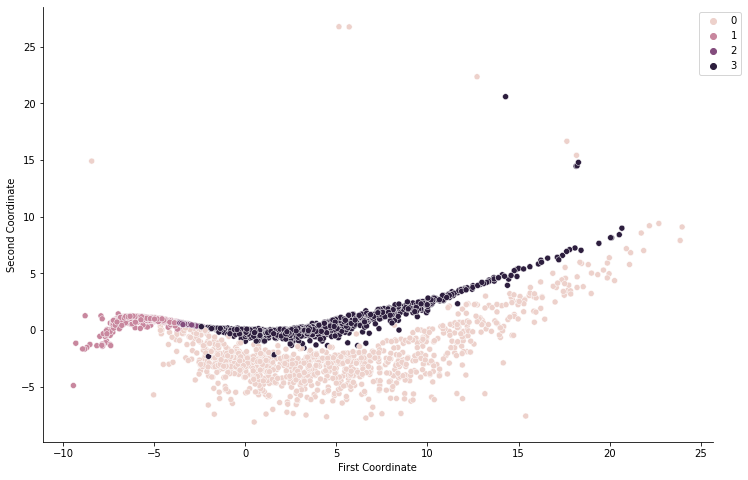

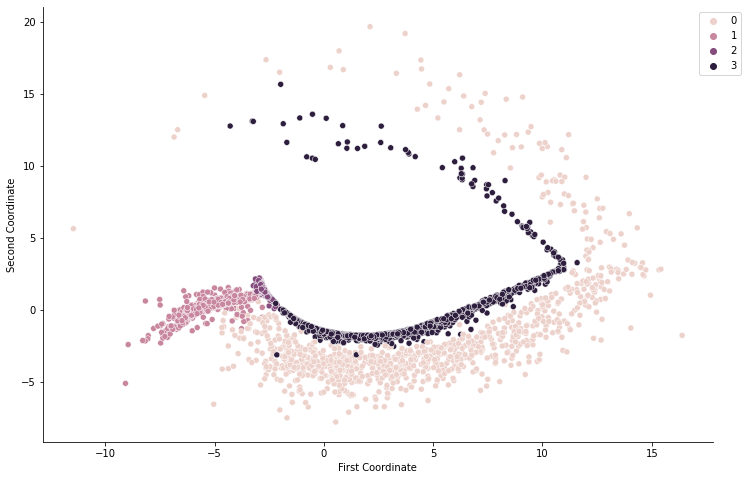

In [21]:
idxs = np.random.choice(X.shape[0], 4000, replace=False)
for n_neigh in [5, 20, 50]:
    Y = isomap(X[idxs, :], n_neigh, 2, plot=False)
    plot_PC(Y, labels[idxs])

---

7. Repeat the exercise with the Anuran dataset from the first exercise.

In [34]:
# reading the data
data = pd.read_csv("../_1/data/Frogs_MFCCs.csv")

# keep features needed
data = data.drop(columns = ['Genus', 'Species', 'RecordID'])
family = data['Family'].values
data = data.drop(columns = ['Family'])

# arrange features into a matrix
X = data.to_numpy(copy=True) 
print("Dimension of the data matrix X: \n (N, D) = ", X.shape)

# normalize data
X = normalize(X)
# shuffle data since thay are family-wise ordereds
random_idx=np.random.permutation(X.shape[0])
X=X[random_idx]
family=family[random_idx]
# train-test split indices
test_idx = np.arange(0, int(0.1*X.shape[0]))

Dimension of the data matrix X: 
 (N, D) =  (7195, 22)


In [35]:
# multinomial logistic regression
var_pc_mlr_sk(X, family, 1, 10, test_idx)

Num PC:  1 Mutual Information:  0.2467 Accuracy:  0.6856745479833102
Num PC:  2 Mutual Information:  0.1524 Accuracy:  0.6675938803894298
Num PC:  3 Mutual Information:  0.1431 Accuracy:  0.6606397774687065
Num PC:  4 Mutual Information:  0.5143 Accuracy:  0.8344923504867872
Num PC:  5 Mutual Information:  0.7257 Accuracy:  0.8929068150208623
Num PC:  6 Mutual Information:  0.7637 Accuracy:  0.9026425591098748
Num PC:  7 Mutual Information:  0.7877 Accuracy:  0.913769123783032
Num PC:  8 Mutual Information:  0.7856 Accuracy:  0.913769123783032
Num PC:  9 Mutual Information:  0.8451 Accuracy:  0.9276773296244785
Num PC:  10 Mutual Information:  0.8425 Accuracy:  0.9262865090403338


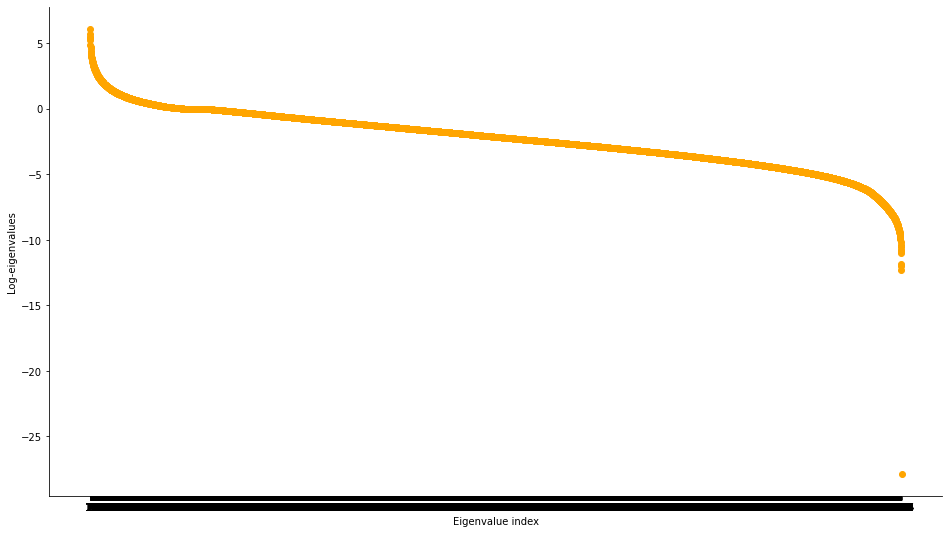

In [36]:
# 2D kernel-PCA
Y = compute_kernel_PCA(X, 2, plot=True)

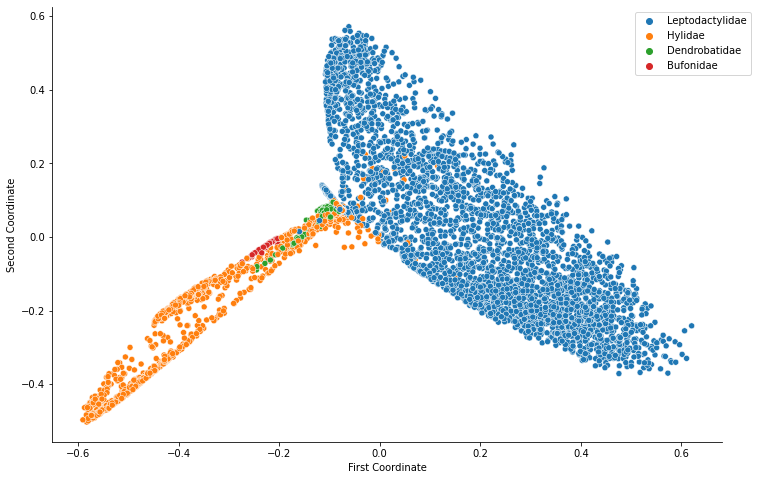

In [37]:
# plot coloring by the label column
plot_PC(Y, family)

In [38]:
# varying size kPCA
var_kpc_mlr_sk(X, family, 1, 10, test_idx)

Num PC:  1 Mutual Information:  0.1546 Accuracy:  0.7246175243393602
Num PC:  2 Mutual Information:  0.2458 Accuracy:  0.760778859527121
Num PC:  3 Mutual Information:  0.2458 Accuracy:  0.760778859527121
Num PC:  4 Mutual Information:  0.2492 Accuracy:  0.7621696801112656
Num PC:  5 Mutual Information:  0.2551 Accuracy:  0.7649513212795549
Num PC:  6 Mutual Information:  0.2551 Accuracy:  0.7649513212795549
Num PC:  7 Mutual Information:  0.4008 Accuracy:  0.7983310152990264
Num PC:  8 Mutual Information:  0.4514 Accuracy:  0.7858136300417247
Num PC:  9 Mutual Information:  0.4514 Accuracy:  0.7858136300417247
Num PC:  10 Mutual Information:  0.4524 Accuracy:  0.7858136300417247


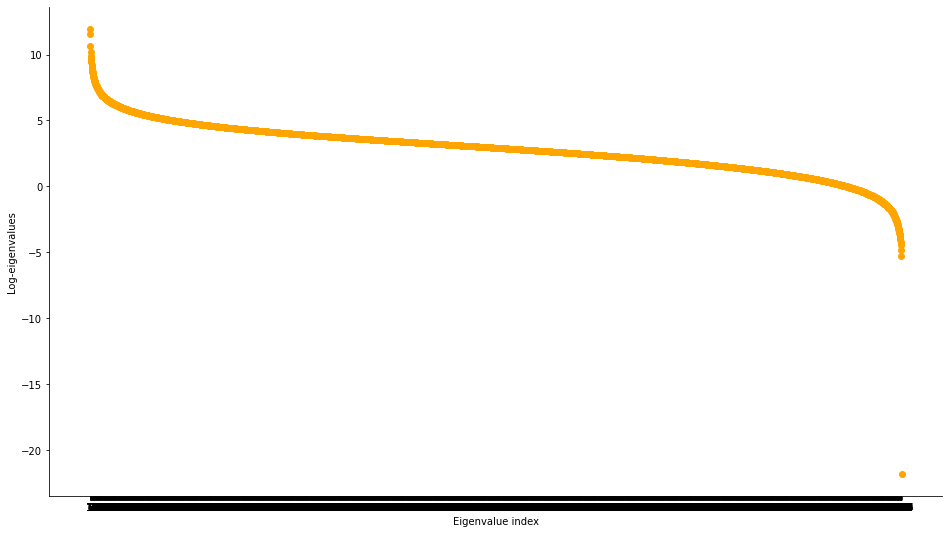

In [39]:
# isomap 
Y = isomap(X[:4000, :], 20, 2, plot=True)

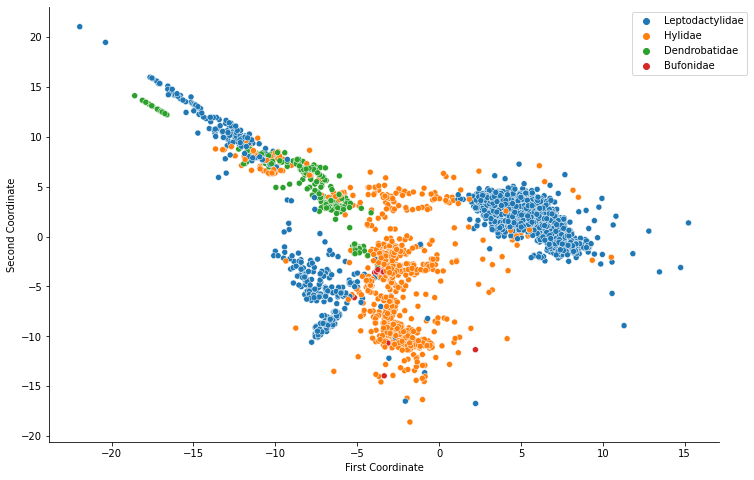

In [40]:
# plot coloring by the label column
plot_PC(Y[:4000, :], family[:4000])